## Variant 2 (Markov Switching)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

from pypfopt import black_litterman, plotting
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### Data Collection

Stock data for each ticker is first retrieved for the 10-year date range. This is downloaded via Yahoo Finance (Python library: yfinance).

Tickers (also known as 'symbols') are used as an identifier for a given stock. A breakdown of ticker and it's respective stock is as follows:

<li>'TSLA' == Tesla
<li>'NVDA' == Nvdia
<li>'AMZN' == Amazon
<li>'META' == Meta
<li>'RIVN' == Rivian Automotive Inc??
<li>'INTC' == Intel Corp
<li>'AMD' == Advanced Micro-Devices<br>

Closing prices ('Adj Close') and logarithmic returns are then calculated. The 10 most recent closing prices for each ticker are printed using tail(10).

In [2]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

# Market-related data
market_data = yf.download("VOO", start=start_date, end=end_date, auto_adjust=True)
market_data['Returns'] = np.log(market_data['Close'] / market_data['Close'].shift(1))  # Log returns
market_returns = market_data['Returns']
market_data = market_data.dropna()
market_prices = yf.download("VOO", start=start_date, end=end_date, auto_adjust=True)
market_prices = market_prices["Close"]

# Ticker-related data
ticker_data = yf.download(tickers, start=start_date, end=end_date)
closing_prices = ticker_data["Close"]
ticker_returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_capitalisation(tickers):
    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_caps

market_data.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed


Price,Close,High,Low,Open,Volume,Returns
Ticker,VOO,VOO,VOO,VOO,VOO,
Date,,,,,,
2023-12-15,425.711884,426.852125,424.876358,425.810186,5281900,-0.001523
2023-12-18,428.120178,428.965513,427.048751,427.235517,4280500,0.005641
2023-12-19,430.725037,430.754524,428.523207,428.611670,4061500,0.006066
2023-12-20,424.507751,431.634042,424.320215,429.857417,5783200,-0.014540
2023-12-21,428.643402,428.998745,425.267778,427.508334,4621600,0.009695
2023-12-22,429.640289,431.170159,427.853784,429.808066,4035200,0.002323
2023-12-26,431.426819,432.236183,429.926528,430.015386,3835800,0.004150
2023-12-27,432.216400,432.334838,430.755629,431.229379,4271000,0.001828


In [3]:
closing_prices.tail(10)

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15,139.149994,149.970001,45.549957,333.645538,48.876141,22.830000,253.500000
2023-12-18,138.899994,154.070007,45.086170,343.308594,50.062801,23.799999,252.080002
2023-12-19,140.149994,153.789993,46.043350,349.026733,49.589939,24.350000,257.220001
2023-12-20,135.470001,152.119995,45.155239,347.950867,48.097359,23.180000,247.139999
2023-12-21,139.910004,153.839996,46.457802,352.742554,48.976116,23.580000,254.500000
2023-12-22,139.600006,153.419998,47.365639,352.045197,48.816162,23.209999,252.539993
2023-12-26,143.410004,153.410004,49.832603,353.479706,49.265030,23.590000,256.609985
2023-12-27,146.070007,153.339996,50.089165,356.468323,49.402988,23.730000,261.440002
2023-12-28,148.759995,153.380005,49.724052,356.956482,49.507965,23.540001,253.179993


### Market Logarithmic Returns

The logarithmic returns are then plotted to gauge a better understanding of the percentage change of returns of an asset over the 10-year period.

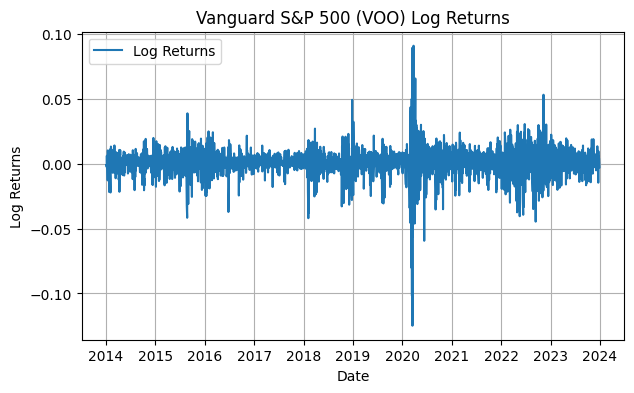

In [4]:
def plot_log_returns(market_data):
    """
    Plots the logarithmic returns of the Vanguard S&P 500 ETF (VOO) over a 10-year date period.

    Parameters:
        market_data (pd.DataFrame): DataFrame containing market data with a 'Returns' column for log returns
    """
    plt.figure(figsize=(7,4))
    plt.plot(market_data.index, market_data['Returns'], label='Log Returns')
    plt.title('Vanguard S&P 500 (VOO) Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

plot_log_returns(market_data)

### Fit Markov-Switching Model

The Markov Switching model is then fitted to the market data, specifically the same logarithmic returns as above, using the Vanguard S&P 500 ETF. This allows you to define the number of regimes (in this case, two regimes are set, to correspond with bullish/bearish market states) - the model determines periods of high and low volatility in the market data, which subsequently corresponds to the number of regimes.

The results are returned directly from the fit_markov_switching_function, however the summary() method is what allows easier visualisation of the results. This method highlights the key parameters that are used to characterise each regime.

In [5]:
def fit_markov_switching(market_data):
    """
    Fits a Markov Switching model using the market data (S&P 500).

    Parameters:
        market_data (pd.DataFrame): DataFrame containing market data with a 'Returns' column for log returns.

    Returns:
        results: Fitted Markov Switching model results
    """
    model = MarkovRegression(market_data['Returns'], k_regimes=2, switching_variance=True)
    results = model.fit()
    
    return results

results = fit_markov_switching(market_data)
results.summary()

c:\Users\chana\OneDrive\Documents\University of Liverpool\Dissertation\IT_Artifact\Black_Litterman_Risk_Parity_Portfolio_Optimisation\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                 2515
Model:               MarkovRegression   Log Likelihood                8315.850
Date:                Sun, 02 Mar 2025   AIC                         -16619.701
Time:                        10:06:56   BIC                         -16584.721
Sample:                             0   HQIC                        -16607.005
                               - 2515                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      7.737      0.000       0.001       0.001
sigma2      3.134e-05   1.73e-06     18.112      0.000     2.8e-05    3.47e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.458      0.145      -0.002       0.000
sigma2         0.0003    1.7e-05     17.543      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9770      0.005    198.770      0.000       0.967       0.987
p[1->0]        0.0436      0.009      4.761      0.000       0.026       0.062
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### Get Regime Probabilities

Regime probabilities are then extracted to gauge the likelihood of the market being in a particular state (regime) at a given time. This helps understand periods of high and low volatility.

In [6]:
# Define the smoothed probabilities for each regime
# by extracting the smoothed marginal probabilities from the results
# from the fitted model
smoothed_probs_regime_0 = results.smoothed_marginal_probabilities[0]
smoothed_probs_regime_1 = results.smoothed_marginal_probabilities[1]

# The transition probabilities matrix highlights
# the probability of transitioning from one regime to another 
# e.g. (from regime 0 -> 1 or a bullish -> bearish state)
transition_probs = results.params[-4:] # last 4 parameters are usually transition probabilities

# The regimes for each time period are then predicted
# to determine which regime the market is in based on each time period
predicted_regimes = results.predicted_marginal_probabilities.idxmax(axis=1)

# Then can extract the means and variances of each regime
# Which can be further visualised if applicable
means = results.params[:2]  
variances = results.params[2:4]  

# Latest smoothed probabilities, transition probabilities,
# predicted regimes, means and variances are then printed
print("Smoothed probabilities for Regime 0:\n", smoothed_probs_regime_0.tail(10))
print("Smoothed probabilities for Regime 1:\n", smoothed_probs_regime_1.tail(10))
print("Transition probabilities:\n", transition_probs)
print("Predicted regimes:\n", predicted_regimes)
print("Means of each regime:", means)
print("Variances of each regime:", variances)

Smoothed probabilities for Regime 0:
 Date
2023-12-15    0.993799
2023-12-18    0.989296
2023-12-19    0.977652
2023-12-20    0.950434
2023-12-21    0.970379
2023-12-22    0.988558
2023-12-26    0.994015
2023-12-27    0.995203
2023-12-28    0.992978
2023-12-29    0.984249
Name: 0, dtype: float64
Smoothed probabilities for Regime 1:
 Date
2023-12-15    0.006201
2023-12-18    0.010704
2023-12-19    0.022348
2023-12-20    0.049566
2023-12-21    0.029621
2023-12-22    0.011442
2023-12-26    0.005985
2023-12-27    0.004797
2023-12-28    0.007022
2023-12-29    0.015751
Name: 1, dtype: float64
Transition probabilities:
 const[0]     0.001159
const[1]    -0.000868
sigma2[0]    0.000031
sigma2[1]    0.000298
dtype: float64
Predicted regimes:
 Date
2014-01-03    0
2014-01-06    0
2014-01-07    0
2014-01-08    0
2014-01-09    0
             ..
2023-12-22    0
2023-12-26    0
2023-12-27    0
2023-12-28    0
2023-12-29    0
Length: 2515, dtype: int64
Means of each regime: p[0->0]    0.977024
p[1->0

### Define View Confidences

Views inherently define the Black Litterman model, and separates it from other allocation techniques. The investor has the chance to define 'views' about the expected returns of an asset, seen in 'markov_relative_views'. This is typically an arbitrary value (views defined here match the values assigned in the benchmark model), which is addressed in alternative model variants.<br><br>The views defined here are relative, which warrants a picking matrix (defined in a later section) to map each view to the ticker and its outperforming/underperforming counterpart.

In [7]:
markov_relative_views = np.array([0.20, 0.15, 0.10, -0.07]).reshape(-1, 1)

def set_view_confidences_for_views(results, markov_relative_views, threshold_bull=0.6, threshold_bear=0.4):
    """
    Assigns view confidences based on the smoothed probabilities from the Markov Switching model

    Parameters:
        results: Results from the Markov Switching model
        markov_relative_views (np.ndarray): Array of relative views.
        threshold_bull (float): Threshold for bull market regime probability. Default is set to  0.6.
        threshold_bear (float): Threshold for bear market regime probability. Default is set to 0.4.

    Returns:
        list: Returns a list of view confidences based on the smoothed probabilities.
    """
    smoothed_probs = results.smoothed_marginal_probabilities
    
    view_confidences = []
    
    # Validate that the number of views 
    # does not exceed the number of time steps
    # otherwise throw a ValueError
    if len(markov_relative_views) > len(smoothed_probs[0]):
        raise ValueError("Number of views exceeds the number of time steps in smoothed probabilities.")
    
    # Iterate over views and assign confidences
    for idx in range(len(markov_relative_views)):
        bull_prob = smoothed_probs[0][idx]
        bear_prob = smoothed_probs[1][idx]
        
        if bull_prob > threshold_bull:
            confidence = bull_prob
        elif bear_prob > threshold_bear:
            confidence = bear_prob
        else:
            confidence = max(bull_prob, bear_prob)
        
        view_confidences.append(confidence)
    
    return view_confidences

markov_adjusted_confidences = set_view_confidences_for_views(results, markov_relative_views, threshold_bull=0.6, threshold_bear=0.4)
markov_adjusted_confidences

C:\Users\chana\AppData\Local\Temp\ipykernel_21900\590353195.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bull_prob = smoothed_probs[0][idx]
C:\Users\chana\AppData\Local\Temp\ipykernel_21900\590353195.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bear_prob = smoothed_probs[1][idx]


[np.float64(0.9855272554176907),
 np.float64(0.9927165517685796),
 np.float64(0.995162371575873),
 np.float64(0.9957036120937879)]

### Filter Regime Returns

The next function filters the market returns based on the identified regimes from the fitted Markov Switching model. This function helps understand how returns differ under different market conditions (i.e. when the market is in a bullish state)

In [8]:
def filter_returns_by_regime(results, market_data):
    smoothed_probs = results.smoothed_marginal_probabilities

    # Handle instance where smoothed_probs is not a DataFrame
    # otherwise, convert it to DataFrame
    if not isinstance(smoothed_probs, pd.DataFrame):
        smoothed_probs = pd.DataFrame(smoothed_probs)

    # Assign most likely regime to each time step
    market_data['Regime'] = smoothed_probs.idxmax(axis=1)

    # Filter returns by regime
    # i.e. returns when regime is 0, 1 etc.
    regime_returns = {
        regime: market_data[market_data['Regime'] == regime]['Returns']
        for regime in range(smoothed_probs.shape[1])
    }

    # Calculate covariance matrices for each regime
    # (required for Black-Litterman model)
    covariance_matrices = {
        regime: market_data[market_data['Regime'] == regime].cov()
        for regime in range(smoothed_probs.shape[1])
    }

    return regime_returns, covariance_matrices

regime_returns, covariance_matrices = filter_returns_by_regime(results, market_data)

for regime, cov_matrix in covariance_matrices.items():
    print(f"Regime {regime} covariance matrix:\n{cov_matrix}\n")

Regime 0 covariance matrix:
Price                  Close          High           Low          Open  \
Ticker                   VOO           VOO           VOO           VOO   
Price   Ticker                                                           
Close   VOO     7.514759e+03  7.542426e+03  7.475187e+03  7.507333e+03   
High    VOO     7.542426e+03  7.570858e+03  7.502975e+03  7.535754e+03   
Low     VOO     7.475187e+03  7.502975e+03  7.436551e+03  7.468565e+03   
Open    VOO     7.507333e+03  7.535754e+03  7.468565e+03  7.501499e+03   
Volume  VOO     7.673628e+07  7.720887e+07  7.618986e+07  7.675622e+07   
Returns         1.649780e-02  1.400578e-02  1.415436e-02  1.154049e-02   
Regime          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

Price                 Volume     Returns Regime  
Ticker                   VOO                     
Price   Ticker                                   
Close   VOO     7.673628e+07    0.016498    0.0  
High    VOO     7.720887e+07   

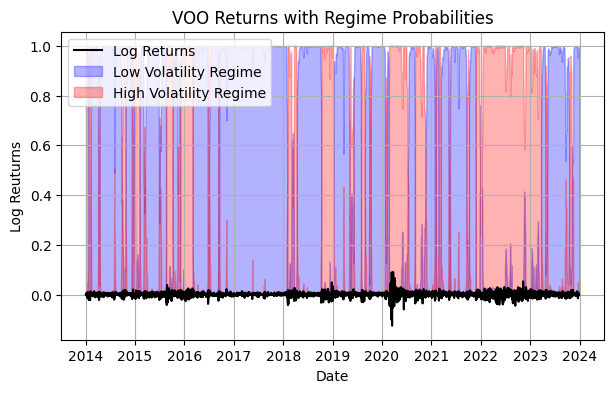

In [9]:
# To visalise when the market is in bull/bear periods
# can see the likelihood of each one occuring using smoothed probabilities
def plot_regime_probabilities(market_data):
    """
    Plots the regime probabilities over 10-year period, highlighting periods of low (purple) and high volatility (red).

    Parameters:
        market_data (pd.DataFrame): DataFrame containing market data with 'Returns' column for log returns.
    """
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(market_data. index, market_data['Returns'], label='Log Returns', color='black')
    
    ax.fill_between(market_data.index, 0, results.smoothed_marginal_probabilities[0], color='blue', alpha=0.3, label='Low Volatility Regime')
    ax.fill_between(market_data.index, 0, results.smoothed_marginal_probabilities[1], color='red', alpha=0.3, label='High Volatility Regime') # Any red sections show the market in high volatility period

    ax.set_title('VOO Returns with Regime Probabilities')
    ax.set_xlabel('Date')
    ax.set_ylabel("Log Reuturns")
    plt.grid()
    ax.legend(loc='upper left')
    plt.show()

plot_regime_probabilities(market_data)

The covariance matrix of asset returns is calculated, from which the covariance and correlation plots are displayed. Both plots are derived from the same data, however the latter provides better visualisation of asset covariances.

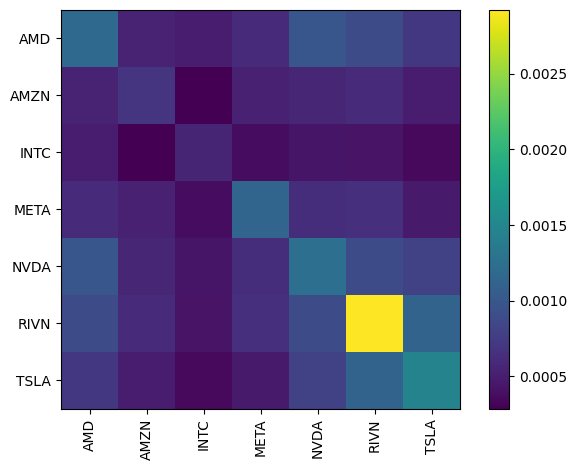

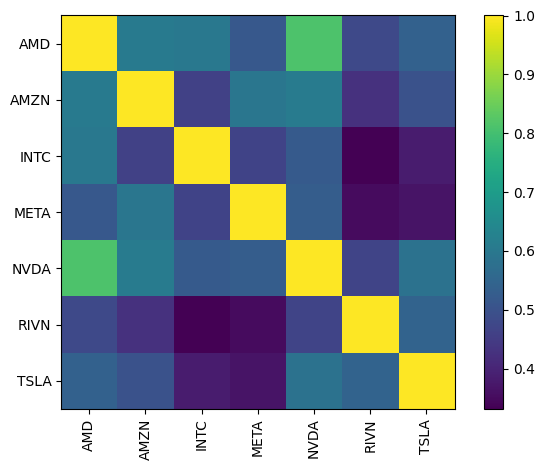

In [10]:
markov_covariance_matrix = ticker_returns.cov()

covariance_plot = plotting.plot_covariance(markov_covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(markov_covariance_matrix, plot_correlation=True)

### Get Prior and Delta

Using the previously defined function, market prices from the Vanguard S&P 500 index and market capitalisations for each ticker can be retrieved. These are used to calculate the 'Prior' and 'Delta'.

<li>Delta represents the risk-aversion co-efficient, and is used to scale the equilibrium returns. This determines the risk aversion of the investor.
<li>Prior is used to calculate the equilibrium returns based on the market portfolio (VOO). This is the benchmark portfolio which will be skewed once investor views are provided in the following section.

In [11]:
market_caps = get_market_capitalisation(tickers)

markov_delta = black_litterman.market_implied_risk_aversion(market_prices)
markov_prior = black_litterman.market_implied_prior_returns(market_caps, markov_delta, markov_covariance_matrix)

markov_prior

Ticker
AMD     0.003118
AMZN    0.002401
INTC    0.001552
META    0.002852
NVDA    0.003590
RIVN    0.003259
TSLA    0.002966
dtype: float64

### Map Views to Tickers

The picking matrix has four rows (each representing a single view, as defined previously), and seven columns (representing the ticker's position in the ticker list). A '1' represents the outperforming ticker, whereas a '-1' represents the underperforming ticker. Each row much subsequently sum to 0 (required for relative views). Based on this matrix, the following views can be extracted:

<ol>
<li>TSLA will outperform AMZN by 20%
<li>NVDA will outperform META by 15%
<li>META will outperform AMD by 10%
<li>INTC will underperform against AMD by -0.7%
</ol>

In [12]:
picking_matrix = np.array([
    [1, 0, -1, 0, 0, 0, 0],  # TSLA > AMZN
    [0, 1, 0, -1, 0, 0, 0],  # NVDA > META
    [0, 0, 0, 1, 0, 0, -1],  # META > AMD
    [0, 0, 0, 0, 0, -1, 1]   # INTC < AMD
])

### Run Black Litterman Model

The Black Litterman model is then called with all previous values, including the covariance matrix, prior, relative views, picking matrix, omega, Markov-adjusted view confidences, tau, and delta.

To show that absolute views have not been used for the model, this has been explicitly set to 'None'. For the omega, Idzorek's method is employed (this is what requires the picking matrix to be defined). In the case that the number of views matches the number of tickers, a picking matrix wouldn't be necessary, as this would have an implicit mapping.

In [13]:
markov_bl = BlackLittermanModel(
    markov_covariance_matrix,
    pi=markov_prior,
    absolute_views=None,
    Q=markov_relative_views,
    P=picking_matrix,
    omega="idzorek",
    view_confidences=markov_adjusted_confidences,
    tau=0.025, 
    risk_aversion=markov_delta
)

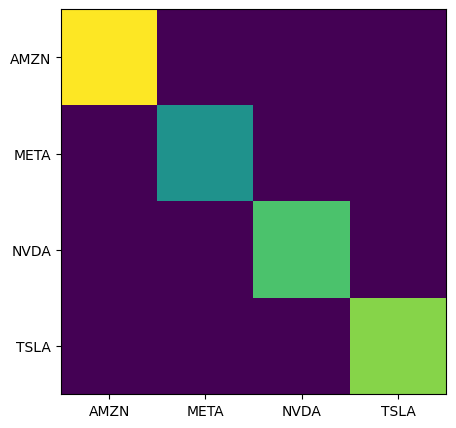

In [14]:
def plot_omega():
    """
    Plots the Black Litterman omega value (view uncertainties)
    for all tickers where a view has been defined.
    """
    
    # Only plot for tickers where views have been defined
    tickers_with_views = ["AMZN", "META", "NVDA", "TSLA"]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(markov_bl.omega)

    ax.set_xticks(np.arange(len(tickers_with_views)))
    ax.set_yticks(np.arange(len(tickers_with_views)))

    ax.set_xticklabels(tickers_with_views)
    ax.set_yticklabels(tickers_with_views)

    plt.show()
    np.diag(markov_bl.omega)

plot_omega()

### Calculate Posterior Returns

Posterior returns are then calculated based on the Black Litterman model which produces a posterior estimate of the returns vector.

In [15]:
markov_bl_returns = markov_bl.bl_returns()
markov_bl_returns

Ticker
AMD     0.148995
AMZN    0.138524
INTC   -0.047826
META   -0.009365
NVDA    0.095810
RIVN   -0.037246
TSLA   -0.107479
dtype: float64

The returns are difficult to visualise on their own, so these are added to a Pandas series alongside the Prior (market implied) and the views determined by the investor so the correlation between the values can be understood. 

In [16]:
markov_relative_views_series = pd.Series(np.nan, index=tickers)
markov_relative_views_series[:len(markov_relative_views)] = markov_relative_views.flatten()

markov_returns_df = pd.DataFrame([markov_prior, markov_bl_returns, pd.Series(markov_relative_views_series)], index=["Prior", "Posterior", "Views"]).T
markov_returns_df

,Prior,Posterior,Views
AMD,0.003118,0.148995,NaN
AMZN,0.002401,0.138524,0.10
INTC,0.001552,-0.047826,NaN
META,0.002852,-0.009365,-0.07
NVDA,0.003590,0.095810,0.15
RIVN,0.003259,-0.037246,NaN
TSLA,0.002966,-0.107479,0.20


<Axes: >

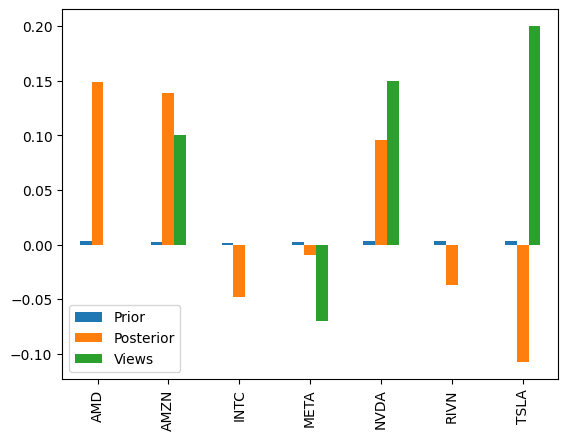

In [17]:
# For better understanding of the above series
# the correlation between the three values are plotted on a bar graph
markov_returns_df.plot.bar()

<Axes: >

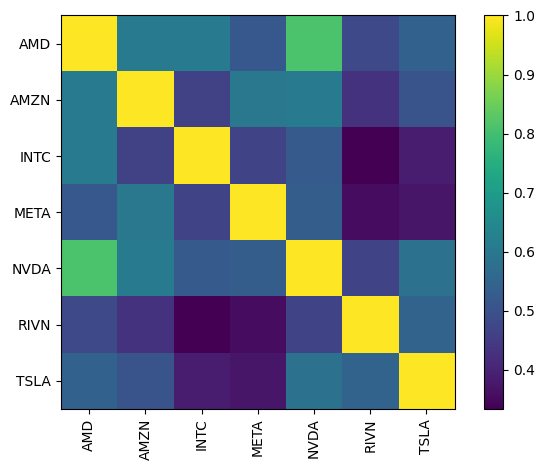

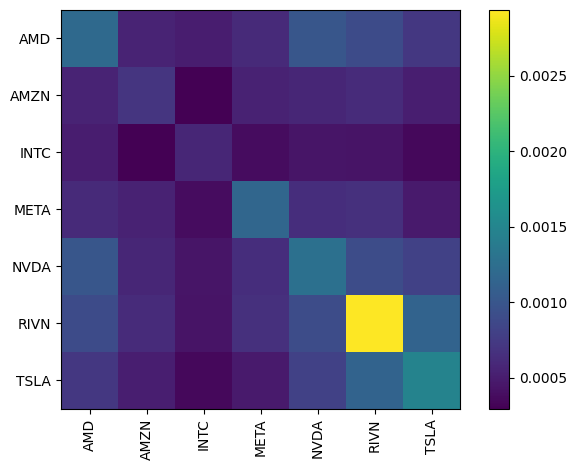

In [18]:
# Calculation of the new posterior covariance matrix
posterior_cov = markov_bl.bl_cov()

# Alongside the plotted matrices
# for the correlation and covariance visualisations
plotting.plot_covariance(posterior_cov, plot_correlation=True)
plotting.plot_covariance(posterior_cov, plot_correlation=False)

### Efficient Frontier Weights

The following section is used to generate the allocation weights based on the Black Litterman returns and posterior covariance matrix. The weights are optimised for both Minimum Variance and Max Sharpe portfolios, which can be used as per the investor's risk tolerance and personal strategy.

The allocations per optimised weights are visualised further down to give a better understanding of how each strategy allocates the given assets.

#### Minimum Volatility

In [19]:
# Initialises the Efficient Frontier 
# using the posterior returns and covariance matrix
ef_1 = EfficientFrontier(markov_bl_returns, posterior_cov)

# Retrieve the Minimum Volatilty portfolio weights
min_vol_weights = ef_1.min_volatility()

# Cleaned weights to ensure they are rounded and sum to 1
cleaned_weights_min_vol = ef_1.clean_weights()

cleaned_weights_min_vol

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.37654),
             ('INTC', 0.57175),
             ('META', 0.01482),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.0369)])

#### Max Sharpe

In [20]:
# Initialises the Efficient Frontier 
# using the posterior returns and covariance matrix
ef_2 = EfficientFrontier(markov_bl_returns, posterior_cov)

# Retrieve the Max Sharpe portfolio weights
max_sharpe_weights = ef_2.max_sharpe()

# Clean the weights to ensure they are rounded and sum to 1
cleaned_weights_max_sharpe = ef_2.clean_weights()

cleaned_weights_max_sharpe

OrderedDict([('AMD', 0.24876),
             ('AMZN', 0.75124),
             ('INTC', 0.0),
             ('META', 0.0),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.0)])

### Plot Asset Allocation Pies

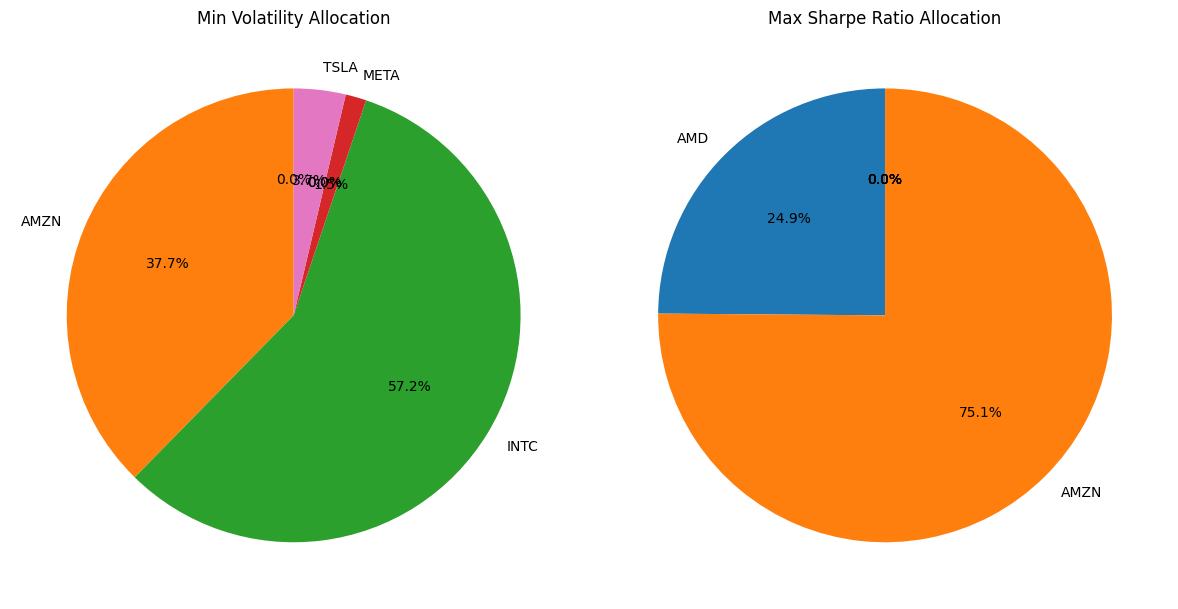

In [21]:
# Set the subplots for both pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Minimum Volaility allocation
pd.Series(cleaned_weights_min_vol).plot.pie(
    ax=axes[0], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Min Volatility Allocation"
)

# Plot Max Sharpe allocation
pd.Series(cleaned_weights_max_sharpe).plot.pie(
    ax=axes[1], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Max Sharpe Ratio Allocation"
)

plt.tight_layout()
plt.show()

### Portfolio Performance

The above allocations are effectively meaningless without an understanding of the annualised performance and risk-adjusted performance. The following section follows the same pattern of optimising for both Min Volatility portfolio and a Max Sharpe portfolio, and utilises the PyPortfolioOpt 'portfolio_performance' function to gauge the portfolio performance for each optimisation.

To breakdown the performance metrics:
- Expected annual return: The expected returns based on the given allocation
- Annual volatility: Used to gauge how risky the allocation is. A more diverse allocation can typically expect to have a lower volatility since the risk is distributed. For the default assets used in this notebook, since they are all in the tech sector, they are more likely to have a higher volatility.
- Sharpe ratio: Used to measure the returns per unit of risk. A higher ratio is better, where anything above 3 is typically considered very good.

#### Minimum Volatility Performance

In [22]:
ef_1.portfolio_performance(verbose=True)

Expected annual return: 2.1%
Annual volatility: 2.1%
Sharpe Ratio: 0.97


(np.float64(0.020711097950733),
 np.float64(0.02142573723016947),
 np.float64(0.9666457554407888))

#### Max Sharpe Performance

In [23]:
ef_2.portfolio_performance(verbose=True)

Expected annual return: 14.1%
Annual volatility: 2.6%
Sharpe Ratio: 5.42


(np.float64(0.1411289478691815),
 np.float64(0.02601921149375841),
 np.float64(5.424028622198489))

### Get Discrete Allocation (DA)

The discrete allocation is retrieved for both the Min Volatility and Max Sharpe portfolios based on a £10,000 portfolio. This allows you to determine the number of shares to buy for each stock, which is helpful to use for a loose translation for a real world portfolio. This is not to be confused with a continuous allocation, which instead allows the investor to purchase fractional (partial) shares.

#### Minimum Volatility DA

In [24]:
latest_prices = get_latest_prices(closing_prices)
da_min_vol = DiscreteAllocation(cleaned_weights_min_vol, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_min_vol.lp_portfolio(verbose=True)

# Quantities of shares that should be bought 
# to have a 10,000£ portfolio
print(allocation)

Funds remaining: 2.16
AMD: allocated 0.000, desired 0.000
AMZN: allocated 0.380, desired 0.377
INTC: allocated 0.570, desired 0.572
META: allocated 0.000, desired 0.015
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.050, desired 0.037
Allocation has RMSE: 0.008
{'AMZN': 25, 'INTC': 115, 'TSLA': 2}


#### Max Sharpe DA

In [25]:
latest_prices = get_latest_prices(closing_prices)
da_max_sharpe = DiscreteAllocation(cleaned_weights_max_sharpe, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_max_sharpe.lp_portfolio(verbose=True)

# Quantities of shares that should be bought 
# to have a 10,000£ portfolio
print(allocation)

Funds remaining: 25.51
AMD: allocated 0.251, desired 0.249
AMZN: allocated 0.746, desired 0.751
INTC: allocated 0.000, desired 0.000
META: allocated 0.000, desired 0.000
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.002, desired 0.000
TSLA: allocated 0.000, desired 0.000
Allocation has RMSE: 0.002
{'AMD': 17, 'AMZN': 49, 'RIVN': 1}


## Sensitivity Analysis

To validate the robustness of each model variant, the input sensitivity of several parameters must be tested to ensure no anomoloies in the data are produced with varying input values.

The following parameters will be validated based on a reasonable range for each value, such that the variance of the model's output can be assessed: 

- Relative views (key parameter for each variant)
- View confidences (key parameter for each variant)
- Prior
- Tau - Currently set to 0.025 as per Idzorek's recommendation, however it would be interesting to see how this affects each model when increased/decreased.

#### Sensitivity to Tau (Uncertainty in Prior)

The first parameter to validate is the effect of tau on the portfolio i.e. what is the uncertainty of the prior? The range of values in tau_values intends to tilt the portfolio either towards the prior or the views based on the level of uncertainty.

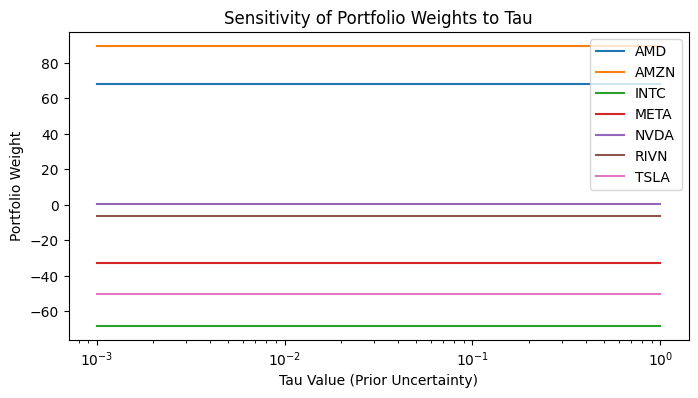

In [27]:
# Log scale from 0.001 to 1 for tau values
tau_values = np.logspace(-3, 0, 5)
results = []

for tau in tau_values:
    bl_model = BlackLittermanModel(
        cov_matrix=markov_covariance_matrix,
        pi=markov_prior, 
        absolute_views=None, 
        Q=markov_relative_views, 
        P=picking_matrix, 
        omega="idzorek", 
        view_confidences=markov_adjusted_confidences, 
        tau=tau, # <-- Using the new Tau
        risk_aversion=markov_delta
    )
    posterior_weights = bl_model.bl_weights()
    results.append(posterior_weights)

posterior_weights_series = pd.Series(posterior_weights)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(posterior_weights_series.index):
    plt.plot(tau_values, [res[ticker] for res in results], label=ticker)

plt.xscale("log")
plt.xlabel("Tau Value (Prior Uncertainty)")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Tau")
plt.legend()
plt.show()

#### Sensitivity to Prior

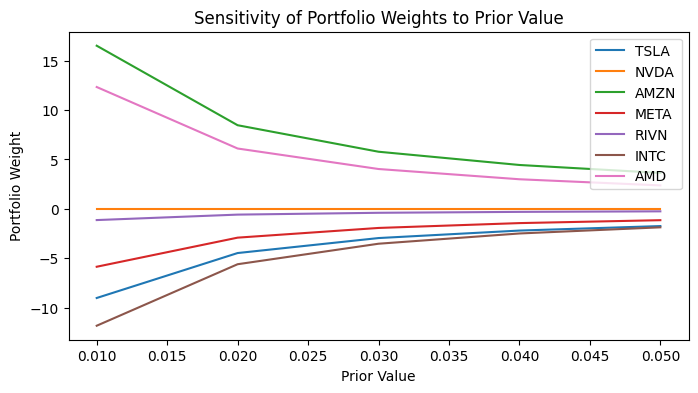

In [28]:
prior_values = np.linspace(0.01, 0.05, 5)
results_prior = []

for prior_value in prior_values:
    prior_test = pd.Series(prior_value, index=tickers)
    
    bl_model_prior = BlackLittermanModel(
        cov_matrix=markov_covariance_matrix,
        pi=prior_test, # <-- Using the new Prior
        absolute_views=None, 
        Q=markov_relative_views, 
        P=picking_matrix, 
        omega="idzorek", 
        view_confidences=markov_adjusted_confidences, 
        tau=tau, 
        risk_aversion=markov_delta
    )
    posterior_weights_prior = bl_model_prior.bl_weights()
    results_prior.append(posterior_weights_prior)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(tickers):
    plt.plot(prior_values, [res[ticker] for res in results_prior], label=ticker)

plt.xlabel("Prior Value")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Prior Value")
plt.legend()
plt.show()

#### Sensitivity to Relative Views

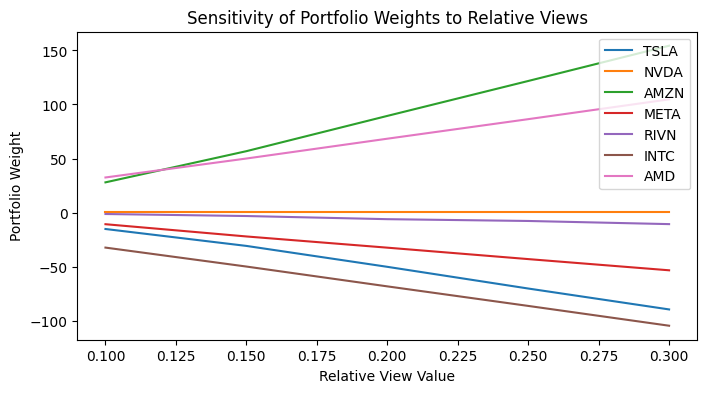

In [29]:
# Test sets of relative investor views
relative_views_range = [
    np.array([0.10, 0.05, 0.02, -0.03]).reshape(-1, 1),
    np.array([0.15, 0.10, 0.05, -0.05]).reshape(-1, 1),
    np.array([0.20, 0.15, 0.10, -0.07]).reshape(-1, 1),
    np.array([0.25, 0.20, 0.15, -0.10]).reshape(-1, 1),
    np.array([0.30, 0.25, 0.20, -0.12]).reshape(-1, 1)
]
results_views = []

for views in relative_views_range:
    bl_model_views = BlackLittermanModel(
        cov_matrix=markov_covariance_matrix,
        pi=markov_prior, 
        absolute_views=None,
        Q=views, # <-- Using the test set of investor views
        P=picking_matrix, 
        omega="idzorek", 
        view_confidences=markov_adjusted_confidences, 
        tau=tau, 
        risk_aversion=markov_delta
    )
    posterior_weights_views = bl_model_views.bl_weights()
    results_views.append(posterior_weights_views)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(tickers):
    plt.plot([views[0][0] for views in relative_views_range], [res[ticker] for res in results_views], label=ticker)

plt.xlabel("Relative View Value")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Relative Views")
plt.legend()
plt.show()

#### Sensitivity to View Confidence Levels

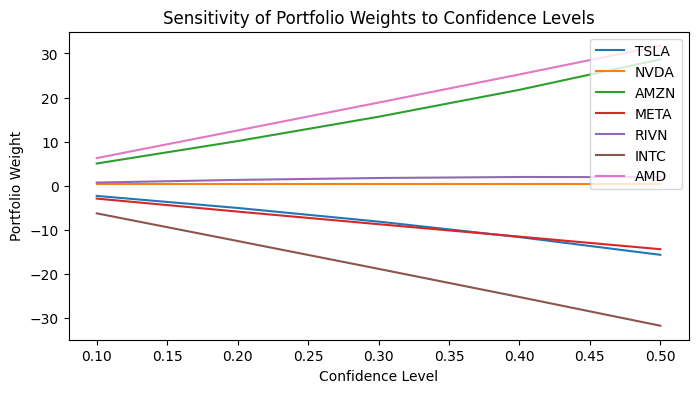

In [30]:
# Sets of view confidence levels
view_confidences = [
    np.array([0.1, 0.1, 0.1, 0.1]),
    np.array([0.2, 0.2, 0.2, 0.2]),
    np.array([0.3, 0.3, 0.3, 0.3]),
    np.array([0.4, 0.4, 0.4, 0.4]),
    np.array([0.5, 0.5, 0.5, 0.5])
]

results_confidence_levels = []

for test_confidences in view_confidences:
    bl_model_views = BlackLittermanModel(
        cov_matrix=markov_covariance_matrix,
        pi=markov_prior, 
        absolute_views=None, 
        Q=markov_relative_views,
        P=picking_matrix, 
        omega="idzorek", 
        view_confidences=test_confidences, # <-- Using the test set of view confidences levels
        tau=tau,
        risk_aversion=markov_delta
    )
    posterior_weights_views = bl_model_views.bl_weights()
    results_confidence_levels.append(posterior_weights_views)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(tickers):
    plt.plot([conf[0] for conf in view_confidences], [res[ticker] for res in results_confidence_levels], label=ticker)

plt.xlabel("Confidence Level")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Confidence Levels")
plt.legend()
plt.show()